In [16]:
import os
import time

import dask.dataframe as dd
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

### Functions

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [3]:
def getFiles(filepath):
    files = []
    for file in os.listdir(data_path):
        if not file.startswith('.'):
            if 'C2' in file:
                files.append(os.path.join(data_path, file))
    return files

In [4]:
# def countCoverage(ddf):
#     # Count number of nodes exceeding threhold
#     ddf['0.1'] = ddf.iloc[:,1:11][ddf.iloc[:,1:11] > 0.1].count(axis=1)
#     ddf['0.2'] = ddf.iloc[:,1:11][ddf.iloc[:,1:11] > 0.2].count(axis=1)
#     ddf['0.3'] = ddf.iloc[:,1:11][ddf.iloc[:,1:11] > 0.3].count(axis=1)
#     ddf['0.4'] = ddf.iloc[:,1:11][ddf.iloc[:,1:11] > 0.4].count(axis=1)
#     ddf['0.5'] = ddf.iloc[:,1:11][ddf.iloc[:,1:11] > 0.5].count(axis=1)
#     ddf['0.6'] = ddf.iloc[:,1:11][ddf.iloc[:,1:11] > 0.6].count(axis=1)
#     ddf['0.7'] = ddf.iloc[:,1:11][ddf.iloc[:,1:11] > 0.7].count(axis=1)
#     ddf['0.8'] = ddf.iloc[:,1:11][ddf.iloc[:,1:11] > 0.8].count(axis=1)
#     ddf['0.9'] = ddf.iloc[:,1:11][ddf.iloc[:,1:11] > 0.9].count(axis=1)

#     # Drop the node columns
#     ddf = ddf.drop(list(ddf.columns[1:11]), axis=1)
    
#     return ddf

In [82]:
def computeStats(ddf, order, bbin):
    zeros = {}
    reaches = {}
    means = {}
    stds = {}
    
    for i in range(len(order)):
        start = time.time()
        
        binn = order[i]
    
        df = ddf[ddf[bbin] == binn].compute()
    
        # Get the number of reaches with 0% coverage in all nodes by bin
        zero = df[df.coverage == 0].shape[0]
        # Get the number of reaches by bin
        reach = df.shape[0]
    
        # Store these
        zeros[binn] = zero
        reaches[binn] = reach
    
        # Drop all reaches with zero coverage
        df = df[df.coverage != 0]
    
        mean = df['coverage'].mean()
        std = df['coverage'].std()
        
        means[binn] = mean * 100
        stds[binn] = std * 100
    
        end = time.time()
    
        print(binn + ' took ' + str((end-start)) + ' s')

    return means, stds, zeros, reaches

### For plotting

In [7]:
cmap = plt.get_cmap('cubehelix', 11)
new_cmap = truncate_colormap(cmap, 0.2, 0.75)

In [8]:
color = []

for i in np.linspace(0, 1, 7):
    color.append(colors.rgb2hex(new_cmap(i)))

In [9]:
palette = sns.color_palette(color)
palette_two = sns.color_palette(color[1::3])
palette_three = sns.color_palette(color[1::2])
palette_four = sns.color_palette(color[0::2])

In [9]:
# palette_three

In [11]:
# palette_four

### Setup

In [17]:
# Order of all possible bins for plotting
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
         '(100, 150]', '(150, 200]', '(200, 500]']

In [18]:
# Thresholds
thresholds = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']

In [19]:
save_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/figures/figures_for_2025_06_16/'

### HUC2_01, Northeast

In [20]:
## Setup
bwidth = 'mean'
bbin = 'Bin'
huc2 = '01'
data_path = '../../narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_' + \
            huc2 + '_2025_05_24_' + bwidth

In [51]:
# Get list of files (currently set to only give PIC2)
files = getFiles(data_path)
len(files)

1295

In [74]:
# Read in all files
ddf_ne = dd.read_parquet(files)

In [75]:
# Calculate percent coverage of full reach
ddf_ne['coverage'] = ddf_ne.iloc[:, 1:10].sum(axis=1) / 10

In [76]:
ddf_ne = ddf_ne[['NHDPlusID', bbin, 'coverage']]

In [96]:
# Compute stats for plotting
means_ne, stds_ne, zeros_ne, reaches_ne = computeStats(ddf=ddf_ne,
                                                       order=order,
                                                       bbin=bbin)

(0, 10] took 5.283813238143921 s
(10, 20] took 4.881563901901245 s
(20, 30] took 5.133153200149536 s
(30, 40] took 4.910643100738525 s
(40, 50] took 4.831814765930176 s
(50, 60] took 5.156495571136475 s
(60, 70] took 4.811460256576538 s
(70, 80] took 4.82489275932312 s
(80, 90] took 5.160086393356323 s
(90, 100] took 4.818723440170288 s
(100, 150] took 5.004305601119995 s
(150, 200] took 5.130329847335815 s
(200, 500] took 4.796426773071289 s


In [22]:
# for i in range(len(thresholds)):

#     thresh = thresholds[i]

#     percent = str(int(float(thresh)*100))

#     # Draw plot with error bars and extra formatting to match seaborn style
#     fig, ax = plt.subplots(figsize=(9,5))
#     ax.errorbar(x=order, y=means_ne[thresh], yerr=stds_ne[thresh],
#                 color=palette_four[0], ecolor=palette_four[0],
#                 marker='o')
#     # ax.set_xlabel('timepoint')
#     # ax.set_ylabel('signal')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     plt.title('Reaches by proportion of nodes that meet or exceed ' + percent +
#           '% coverage, excluding reaches with 0% coverage')
    
#     plt.xlabel('Width Bin [m]')
#     plt.ylabel('Number of nodes that exceed ' + percent + '% coverage')
#     plt.xticks(rotation=-45)
    
#     plt.show()

### HUC2_08, Southeast

In [90]:
## Setup
bwidth = 'mean'
bbin = 'Bin'
huc2 = '08'
data_path = '../../narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_' + \
            huc2 + '_2025_05_24_' + bwidth

In [91]:
# Get list of files
files = getFiles(data_path)
len(files)

1686

In [92]:
ddf_se = dd.read_parquet(files)

In [93]:
# Calculate percent coverage of full reach
ddf_se['coverage'] = ddf_se.iloc[:, 1:10].sum(axis=1) / 10

In [94]:
ddf_se = ddf_se[['NHDPlusID', bbin, 'coverage']]

In [97]:
# Compute stats for plotting
means_se, stds_se, zeros_se, reaches_se = computeStats(ddf=ddf_se,
                                                       order=order,
                                                       bbin=bbin)

(0, 10] took 7.277224063873291 s
(10, 20] took 6.949554204940796 s
(20, 30] took 6.561356544494629 s
(30, 40] took 6.8257904052734375 s
(40, 50] took 6.5439112186431885 s
(50, 60] took 6.542690753936768 s
(60, 70] took 6.779179573059082 s
(70, 80] took 6.715306043624878 s
(80, 90] took 6.801755905151367 s
(90, 100] took 6.554521083831787 s
(100, 150] took 6.522902727127075 s
(150, 200] took 6.765836238861084 s
(200, 500] took 6.5463316440582275 s


### HUC2_15, Southwest

In [99]:
## Setup
bwidth = 'mean'
bbin = 'Bin'
huc2 = '15'
data_path = '../../narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_' + \
            huc2 + '_2025_05_24_' + bwidth

In [100]:
# Get list of files
files = getFiles(data_path)
len(files)

2412

In [101]:
ddf_sw = dd.read_parquet(files)

In [102]:
# Calculate percent coverage of full reach
ddf_sw['coverage'] = ddf_sw.iloc[:, 1:10].sum(axis=1) / 10

In [103]:
ddf_sw = ddf_sw[['NHDPlusID', bbin, 'coverage']]

In [104]:
# Compute stats for plotting
means_sw, stds_sw, zeros_sw, reaches_sw = computeStats(ddf=ddf_sw,
                                                       order=order,
                                                       bbin=bbin)

(0, 10] took 10.799799680709839 s
(10, 20] took 9.673309326171875 s
(20, 30] took 9.307575941085815 s
(30, 40] took 9.43607783317566 s
(40, 50] took 9.493487358093262 s
(50, 60] took 9.207165241241455 s
(60, 70] took 9.604838609695435 s
(70, 80] took 9.462773561477661 s
(80, 90] took 9.224887132644653 s
(90, 100] took 9.452691793441772 s
(100, 150] took 9.20216155052185 s
(150, 200] took 9.431726932525635 s
(200, 500] took 9.609633445739746 s


### HUC2_17, Northwest

In [105]:
## Setup
bwidth = 'mean'
bbin = 'Bin'
huc2 = '17'
data_path = '../../narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_' + \
            huc2 + '_2025_05_24_' + bwidth

In [106]:
# Get list of files
files = getFiles(data_path)
len(files)

4709

In [107]:
ddf_nw = dd.read_parquet(files)

In [108]:
# Calculate percent coverage of full reach
ddf_nw['coverage'] = ddf_nw.iloc[:, 1:10].sum(axis=1) / 10

In [109]:
ddf_nw = ddf_nw[['NHDPlusID', bbin, 'coverage']]

In [110]:
# Compute stats for plotting
means_nw, stds_nw, zeros_nw, reaches_nw = computeStats(ddf=ddf_nw,
                                                       order=order,
                                                       bbin=bbin)

(0, 10] took 30.415148496627808 s
(10, 20] took 25.127058744430542 s
(20, 30] took 24.980258464813232 s
(30, 40] took 24.164836406707764 s
(40, 50] took 24.247780084609985 s
(50, 60] took 24.335137128829956 s
(60, 70] took 24.09262776374817 s
(70, 80] took 24.33734369277954 s
(80, 90] took 24.409315586090088 s
(90, 100] took 24.0935378074646 s
(100, 150] took 24.27802324295044 s
(150, 200] took 24.203415393829346 s
(200, 500] took 24.18701672554016 s


In [111]:
means_nw

{'(0, 10]': np.float64(0.08254424493385717),
 '(10, 20]': np.float64(0.16653911535504226),
 '(20, 30]': np.float64(0.2243359379289607),
 '(30, 40]': np.float64(0.2488200216038767),
 '(40, 50]': np.float64(0.25538687584248354),
 '(50, 60]': np.float64(0.27213548727272663),
 '(60, 70]': np.float64(0.3135727623059922),
 '(70, 80]': np.float64(0.24762907668676148),
 '(80, 90]': np.float64(0.25418517189637624),
 '(90, 100]': np.float64(0.22865293726554234),
 '(100, 150]': np.float64(0.3263672083692906),
 '(150, 200]': np.float64(0.2630536626287721),
 '(200, 500]': np.float64(0.27425746763081615)}

### Four

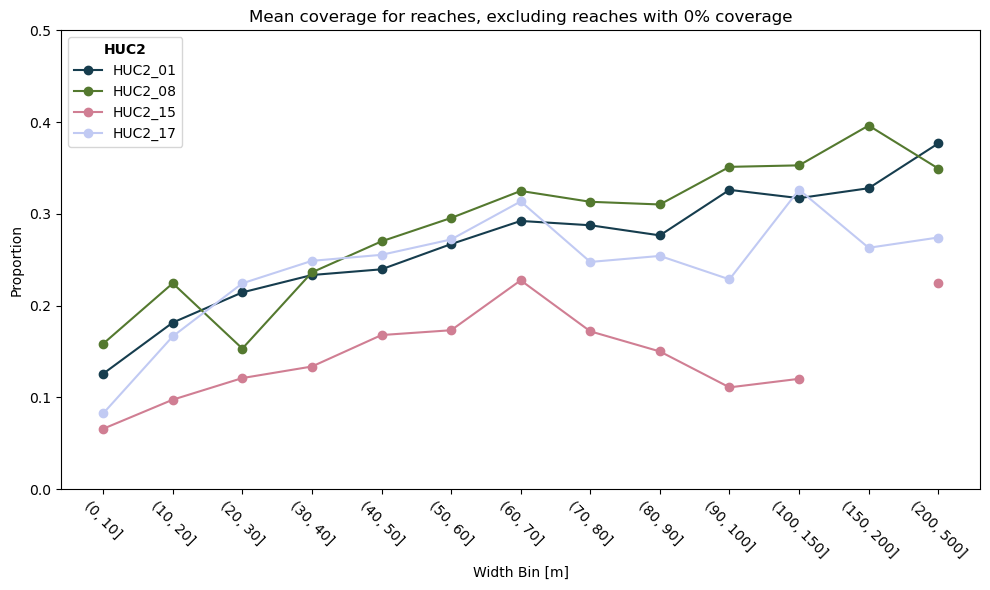

In [122]:
# for i in range(len(thresholds)):

# i = 4

# thresh = thresholds[i]

# percent = str(int(float(thresh)*100))

# Draw plot with error bars and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(10,6))

ax.errorbar(x=order, y=list(means_ne.values()),
            # yerr=stds_ne[thresh],
            color=palette_four[0], ecolor=palette_four[0],
            # alpha=0.7,
            capsize=5,
            marker='o', label='HUC2_01')

ax.errorbar(x=order, y=list(means_se.values()),
            # yerr=stds_se[thresh],
            color=palette_four[1], ecolor=palette_four[1],
            # alpha=0.7, 
            capsize=5,
            marker='o', label='HUC2_08')

ax.errorbar(x=order, y=list(means_sw.values()),
            # yerr=stds_sw[thresh],
            color=palette_four[2], ecolor=palette_four[2],
            # alpha=0.7,
            capsize=5,
            marker='o', label='HUC2_15')

ax.errorbar(x=order, y=list(means_nw.values()),
            # yerr=stds_nw[thresh],
            color=palette_four[3], ecolor=palette_four[3],
            # alpha=0.7,
            # capsize=5,
            marker='o', label='HUC2_17')

ax.set_title('Mean coverage for reaches, excluding reaches with 0% coverage')

ax.set_xlabel('Width Bin [m]')
ax.set_ylabel('Proportion')


plt.legend(title='HUC2', loc='upper left',
           title_fontproperties={'weight': 'bold'})
plt.xticks(rotation=-45)
plt.ylim(0,0.5)

plt.tight_layout()
plt.show()

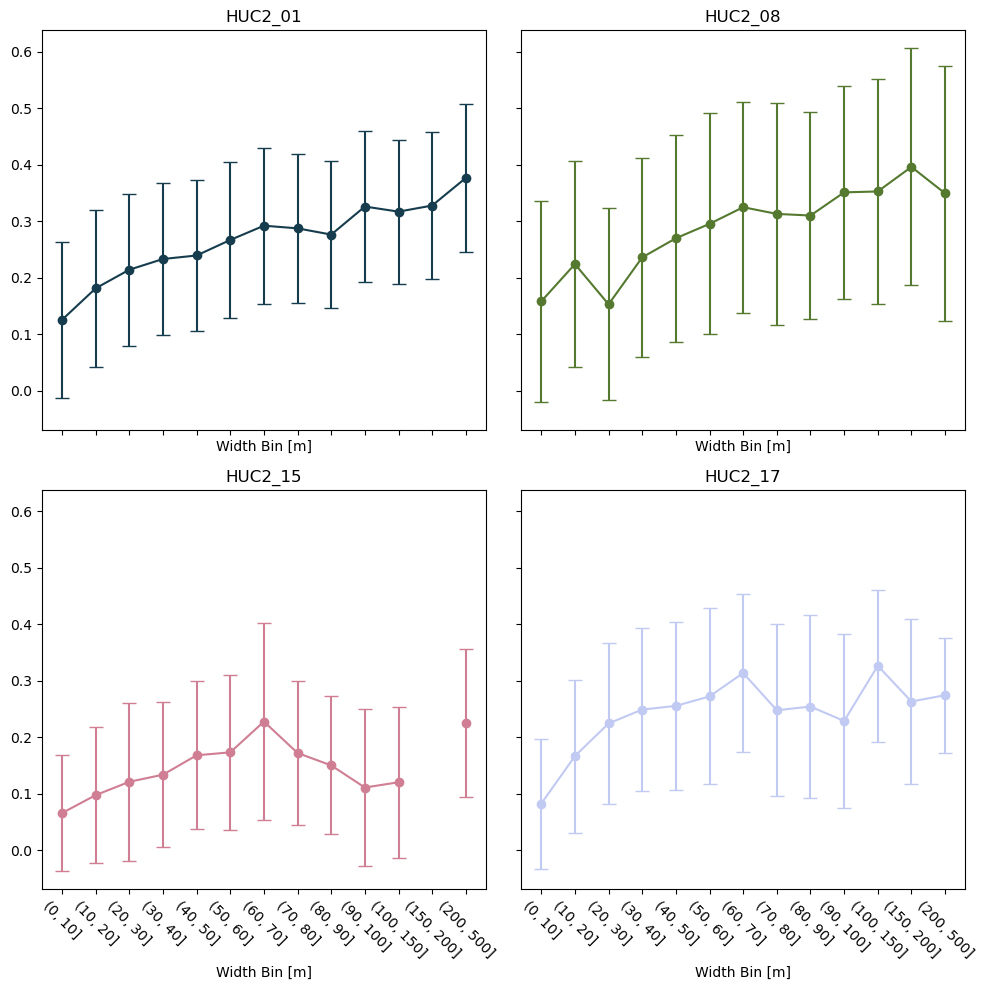

In [121]:
# Set threshold
# i = 4
# thresh = thresholds[i]
# percent = str(int(float(thresh) * 100))

# Set up 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

# Region data dictionary for iteration
regions = {
    'HUC2_01': (list(means_ne.values()), list(stds_ne.values()), palette_four[0]),
    'HUC2_08': (list(means_se.values()), list(stds_se.values()), palette_four[1]),
    'HUC2_15': (list(means_sw.values()), list(stds_sw.values()), palette_four[2]),
    'HUC2_17': (list(means_nw.values()), list(stds_nw.values()), palette_four[3]),
}

# Flatten axes array for easy indexing
axs = axs.flatten()

# Plot each region in its own subplot
for ax, (region, (mean_vals, std_vals, color)) in zip(axs, regions.items()):
    ax.errorbar(x=order, y=mean_vals, yerr=std_vals,
                color=color, ecolor=color,
                alpha=1, capsize=5, 
                marker='o', label=region)

    ax.set_title(region)
    ax.set_xlabel('Width Bin [m]')
    # ax.set_ylabel(f'# of Nodes ≥ {percent}% Coverage')
    ax.tick_params(axis='x', rotation=-45)

# Add overall title
# plt.suptitle('Reaches by mean number of nodes that meet or exceed ' + percent +
#              '% coverage, excluding reaches with 0% coverage')
plt.tight_layout()
plt.show()

/tmp/ipykernel_3081715/304374042.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(ax0.get_xticklabels(), rotation=-45)
/tmp/ipykernel_3081715/304374042.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


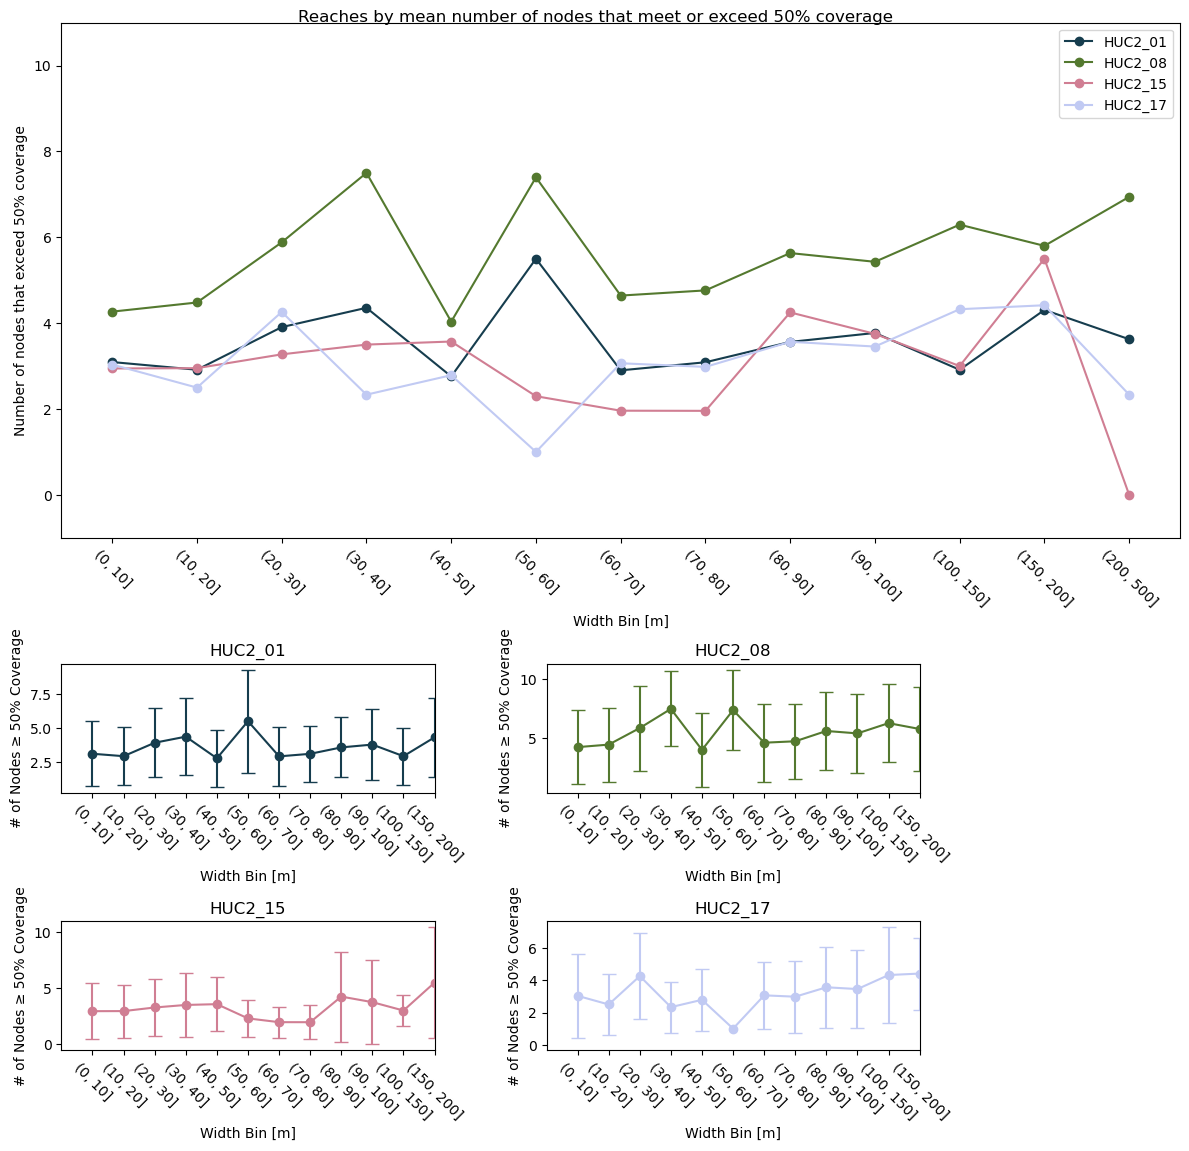

In [171]:
i = 4
thresh = thresholds[i]
percent = str(int(float(thresh) * 100))

fig = plt.figure(figsize=(12, 16), layout='constrained')
gs = gridspec.GridSpec(3, 2
                       , height_ratios=[2, 1.5, 1.5]
                       , width_ratios=[2, 0.5]
                      )

# First plot (spans both columns)
ax0 = fig.add_subplot(gs[0, :])

ax0.errorbar(x=order, y=means_ne[thresh], color=palette_four[0], ecolor=palette_four[0],
             capsize=5, marker='o', label='HUC2_01')
ax0.errorbar(x=order, y=means_se[thresh], color=palette_four[1], ecolor=palette_four[1],
             capsize=5, marker='o', label='HUC2_08')
ax0.errorbar(x=order, y=means_sw[thresh], color=palette_four[2], ecolor=palette_four[2],
             capsize=5, marker='o', label='HUC2_15')
ax0.errorbar(x=order, y=means_nw[thresh], color=palette_four[3], ecolor=palette_four[3],
             capsize=5, marker='o', label='HUC2_17')

ax0.set_xlabel('Width Bin [m]')
ax0.set_ylabel(f'Number of nodes that exceed {percent}% coverage')
ax0.legend()
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=-45)
ax0.set_ylim(-1, 11)

gs2 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1, 0]
                                       ,
                                       wspace=0.3, hspace=1
                                      )

regions = {
    'HUC2_01': (means_ne[thresh], stds_ne[thresh], palette_four[0]),
    'HUC2_08': (means_se[thresh], stds_se[thresh], palette_four[1]),
    'HUC2_15': (means_sw[thresh], stds_sw[thresh], palette_four[2]),
    'HUC2_17': (means_nw[thresh], stds_nw[thresh], palette_four[3]),
}

axs = [fig.add_subplot(gs2[i]) for i in range(4)]

for ax, (region, (mean_vals, std_vals, color)) in zip(axs, regions.items()):
    ax.errorbar(x=order, y=mean_vals, yerr=std_vals, color=color, ecolor=color,
                capsize=5, marker='o', label=region)
    ax.set_title(region)
    ax.set_xlim(-1,11)
    ax.set_xlabel('Width Bin [m]')
    ax.set_ylabel(f'# of Nodes ≥ {percent}% Coverage')
    ax.tick_params(axis='x', rotation=-45)

plt.suptitle(f'Reaches by mean number of nodes that meet or exceed {percent}% coverage')
plt.tight_layout()
# plt.const
plt.show()


In [ ]:
for i in range(len(thresholds)):
    
    # Get ne reaches at threshold
    ne = ddf_ne_melted[ddf_ne_melted['threshold'] == thresholds[i]].reset_index()#.drop(columns='index')
    # ne = ne.sample(frac=0.05)
    ne = ne.compute()
    
    zeros = ne[ne.coverage == 0].count()
    reaches = ne.shape[0]
    ne_zeros = round(((zeros['coverage']/reaches)*100), 1)
    
    ne = ne[ne.coverage != 0]
    if ne.shape[0] > 100000:
        ne = ne.sample(100000)
    ne['huc2'] = '01'
    
    # Get se reaches at threshold
    se = ddf_se_melted[ddf_se_melted['threshold'] == thresholds[i]].reset_index().drop(columns='index')
    # se = se.sample(frac=0.05)
    se = se.compute()
    
    zeros = se[se.coverage == 0].count()
    reaches = se.shape[0]
    se_zeros = round(((zeros['coverage']/reaches)*100), 1)
    
    se = se[se.coverage != 0]
    if se.shape[0] > 100000:
        se = se.sample(100000)
    se['huc2'] = '08'
    
    # Get sw reaches
    sw = ddf_sw_melted[ddf_sw_melted['threshold'] == thresholds[i]].reset_index().drop(columns='index')
    # sw = sw.sample(frac=0.05)
    sw = sw.compute()
    
    zeros = sw[sw.coverage == 0].count()
    reaches = sw.shape[0]
    sw_zeros = round(((zeros['coverage']/reaches)*100), 1)
    
    sw = sw[sw.coverage != 0]
    if sw.shape[0] > 100000:
        sw = sw.sample(100000)
    sw['huc2'] = '15'
    
    # Get nw reaches
    nw = ddf_nw_melted[ddf_nw_melted['threshold'] == thresholds[i]].reset_index().drop(columns='index')
    # nw = nw.sample(frac=0.05)
    nw = nw.compute()
    
    zeros = nw[nw.coverage == 0].count()
    reaches = nw.shape[0]
    nw_zeros = round(((zeros['coverage']/reaches)*100), 1)
    
    nw = nw[nw.coverage != 0]
    if nw.shape[0] > 100000:
        nw = nw.sample(100000)
    nw['huc2'] = '17'
    
    #     # Get combined reaches at 10% threshold
    #     both = pd.concat(objs=[ne, sw], axis=0).reset_index()
    
    #     combo = both.copy()
    #     combo['huc2'] = 'combined'
    
    combined = pd.concat(objs=[ne, se, sw, nw], axis=0).reset_index().drop(columns='index')
    
    del ne, se, sw, nw
    
    percent = str(int(float(thresholds[i])*100))
    
    fig, ax = plt.subplots(figsize=(14,8))
    sns.boxplot(data=combined, x='Bin', y='coverage',
                order=order,
                hue='huc2', palette=palette_four,
                legend=True,
                saturation=1, showmeans=True,
                fliersize=2, linewidth=2,
                boxprops=dict(alpha=0.9),
                meanprops={'marker':'o',
                           'markerfacecolor':'k',
                           'markeredgecolor':'k',
                           'markersize':'8'})
    
    plt.title('Reaches by proportion of nodes that meet or exceed ' + percent +
              '% coverage, excluding reaches with 0% coverage\nHUC2_01: ' +
              str(ne_zeros) + '% of reaches have 0% coverage in all nodes\nHUC2_08: ' +
              str(se_zeros)+ '% of reaches have 0% coverage in all nodes\nHUC2_15: ' +
              str(sw_zeros) + '% of reaches have 0% coverage in all nodes\nHUC2_17: ' +
              str(nw_zeros) + '% of reaches have 0% coverage in all nodes')
    
    plt.legend(title='HUC2', loc='upper left',
               title_fontproperties={'weight': 'bold'})
    
    plt.xlabel('Width Bin [m]')
    plt.ylabel('Number of nodes that exceed ' + percent + '% coverage')
    plt.xticks(rotation=-45)
    
    plt.savefig(save_path + 'threshold_four_hucs_mean_' + percent + '.png')

    del combined

### Combined

In [ ]:
for i in range(5, len(thresholds)):

    zeros = 0
    reaches = 0
    
    # Get ne reaches at threshold
    ne = ddf_ne_melted[ddf_ne_melted['threshold'] == thresholds[i]].reset_index()#.drop(columns='index')
    # ne = ne.sample(frac=0.05)
    ne = ne.compute()
    
    zeros += ne[ne.coverage == 0].count()
    reaches += ne.shape[0]
    
    ne = ne[ne.coverage != 0]
    if ne.shape[0] > 100000:
        ne = ne.sample(100000)
    
    # Get se reaches at threshold
    se = ddf_se_melted[ddf_se_melted['threshold'] == thresholds[i]].reset_index().drop(columns='index')
    # se = se.sample(frac=0.05)
    se = se.compute()
    
    zeros += se[se.coverage == 0].count()
    reaches += se.shape[0]
    
    se = se[se.coverage != 0]
    if se.shape[0] > 100000:
        se = se.sample(100000)
    
    # Get sw reaches
    sw = ddf_sw_melted[ddf_sw_melted['threshold'] == thresholds[i]].reset_index().drop(columns='index')
    # sw = sw.sample(frac=0.05)
    sw = sw.compute()
    
    zeros += sw[sw.coverage == 0].count()
    reaches += sw.shape[0]
    
    sw = sw[sw.coverage != 0]
    if sw.shape[0] > 100000:
        sw = sw.sample(100000)
    
    # Get nw reaches
    nw = ddf_nw_melted[ddf_nw_melted['threshold'] == thresholds[i]].reset_index().drop(columns='index')
    # nw = nw.sample(frac=0.05)
    nw = nw.compute()
    
    zeros += nw[nw.coverage == 0].count()
    reaches += nw.shape[0]
    
    nw = nw[nw.coverage != 0]
    if nw.shape[0] > 100000:
        nw = nw.sample(100000)
    
    #     # Get combined reaches at 10% threshold
    #     both = pd.concat(objs=[ne, sw], axis=0).reset_index()
    
    #     combo = both.copy()
    #     combo['huc2'] = 'combined'
    
    combined = pd.concat(objs=[ne, se, sw, nw], axis=0).reset_index().drop(columns='index')
    
    del ne, se, sw, nw
    
    percent = str(int(float(thresholds[i])*100))

    all_zeros = round(((zeros['coverage']/reaches)*100), 1)

    fig, ax = plt.subplots(figsize=(14,8))
    sns.boxplot(data=combined, x='Bin', y='coverage',
                order=order,
                color=palette[3],
                saturation=1, showmeans=True,
                fliersize=2, linewidth=2,
                boxprops=dict(alpha=0.8),
                meanprops={'marker':'o',
                           'markerfacecolor':'k',
                           'markeredgecolor':'k',
                           'markersize':'8'})

    plt.title('Reaches by proportion of nodes that meet or exceed ' + percent +
              '% coverage, excluding reaches with 0% coverage\n' + str(all_zeros) +
              '% of reaches have 0% coverage in all nodes')

    patch = mpatches.Patch(color=palette[3], label='combined')
    plt.legend(handles=[patch], title='HUC2', loc='upper left',
               title_fontproperties={'weight': 'bold'})

    plt.xticks(rotation=-45)

    plt.xlabel('Width Bin [m]')
    plt.ylabel('Number of nodes that exceed ' + percent + '% coverage')

    plt.savefig(save_path + 'threshold_combined_mean_' + percent + '.png')

    del combined

### All three

In [ ]:
for i in range(len(thresholds)):

    # Get ne reaches at threshold
    ne = ddf_ne_melted[ddf_ne_melted['threshold'] == thresholds[i]]
    ne = ne.compute().reset_index().drop(columns=['NHDPlusID', 'index'])

    zeros = ne[ne.coverage == 0].count()
    reaches = ne.shape[0]
    ne_zeros = round(((zeros['coverage']/reaches)*100), 1)

    ne = ne[ne.coverage != 0]
    if ne.shape[0] > 100000:
        ne = ne.sample(100000)
    ne['huc2'] = '01'

    # Get sw reaches
    sw = ddf_sw_melted[ddf_sw_melted['threshold'] == thresholds[i]]
    sw = sw.compute().reset_index().drop(columns=['NHDPlusID', 'index'])

    zeros = sw[sw.coverage == 0].count()
    reaches = sw.shape[0]
    sw_zeros = round(((zeros['coverage']/reaches)*100), 1)

    sw = sw[sw.coverage != 0]
    if sw.shape[0] > 100000:
        sw = sw.sample(100000)
    sw['huc2'] = '15'

    # Get combined reaches at 10% threshold
    both = pd.concat(objs=[ne, sw], axis=0).reset_index()

    combo = both.copy()
    combo['huc2'] = 'combined'

    combined = pd.concat(objs=[ne, sw, combo], axis=0).reset_index().drop(columns=['index'])

    del ne, sw, combo

    percent = str(int(thresholds[i]*100))

    fig, ax = plt.subplots(figsize=(12,6))
    sns.boxplot(data=combined, x='Bin', y='coverage',
                order=order,
                hue='huc2', palette=palette,
                legend=True,
                saturation=1, showmeans=True,
                fliersize=2, linewidth=2,
                boxprops=dict(alpha=0.8),
                meanprops={'marker':'o',
                           'markerfacecolor':'k',
                           'markeredgecolor':'k',
                           'markersize':'8'})

    plt.title('Reaches with at least ' + percent +
              '% coverage in each node, excluding reaches with 0% coverage\nHUC2_01: ' + str(ne_zeros) +
              '% of reaches have 0% coverage in all nodes\nHUC2_15: ' +
              str(sw_zeros) + '% of reaches have 0% coverage in all nodes')

    plt.legend(title='HUC2', loc='upper right',
               title_fontproperties={'weight': 'bold'})

    plt.xlabel('Width Bin [m]')
    plt.ylabel('Reaches with at least ' + percent + '% coverage')
    plt.xticks(rotation=-45)

    plt.savefig(save_path + 'threshold_all_three_mean_' + percent + '.png')

### Combined old

In [ ]:
for i in range(len(thresholds)):
    # Make combined dataframe
    ddf_combo = dd.concat(dfs=[ddf_ne_melted, ddf_sw_melted], axis=0)

    # Get combined reaches at 10% threshold
    ddf_combo = ddf_combo[(ddf_combo['threshold'] == thresholds[i])]
    combo = ddf_combo.compute().drop(columns=['NHDPlusID']).reset_index()
    combo = combo.drop(columns=['index', 'threshold'])
    combo['coverage'] = combo['coverage']*100
    # combo['huc2'] = '01, 15'

    percent = str(int(thresholds[i]*100))

    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(x='Bin', y='coverage',
                data=combo,
                order=order,
                color=color[2],
                saturation=1, showmeans=True,
                fliersize=2, linewidth=2,
                boxprops=dict(alpha=0.8),
                meanprops={'marker':'o',
                           'markerfacecolor':'k',
                           'markeredgecolor':'k',
                           'markersize':'8'})

    plt.title('Reaches with at least ' + percent +'% coverage in each node, HUC2_01 and HUC2_15')
    plt.xticks(rotation=-45)

    plt.xlabel('Width Bin [m]')
    plt.ylabel('Detected [%]')

    plt.savefig('./figures_for_2025_03_06/threshold_combined_mean_' + percent + '.png')

### Side-by-side old

In [ ]:
for i in range(len(thresholds)):

    # Get ne reaches at 10% threshold
    ddf_ne_thresh = ddf_ne[(ddf_ne['threshold'] == thresholds[i])]
    ne = ddf_ne_thresh.compute().drop(columns=['NHDPlusID']).reset_index()
    ne = ne.drop(columns=['index', 'threshold'])
    ne['coverage'] = ne['coverage']*100
    ne['huc2'] = '01'

    # Get sw reaches at 10% threshold
    ddf_sw_melted_thresh = ddf_sw_melted[(ddf_sw_melted['threshold'] == thresholds[i])]
    sw = ddf_sw_melted_thresh.compute().drop(columns=['NHDPlusID']).reset_index()
    sw = sw.drop(columns=['index', 'threshold'])
    sw['coverage'] = sw['coverage']*100
    sw['huc2'] = '15'

    combo = pd.concat(objs=[ne, sw], axis=0).reset_index()

    del ne, sw

    percent = str(int(thresholds[i]*100))

    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(x='Bin', y='coverage', hue='huc2',
                data=combo, order=order,
                palette=palette_two,
                legend=True,
                saturation=1, showmeans=True,
                fliersize=2, linewidth=2,
                boxprops=dict(alpha=0.8),
                meanprops={'marker':'o',
                           'markerfacecolor':'k',
                           'markeredgecolor':'k',
                           'markersize':'8'})

    plt.legend(title='HUC2', loc='upper right')

    plt.title('Reaches with at least ' + percent +'% coverage in each node, HUC2_01 and HUC2_15')
    plt.xlabel('Width Bin [m]')
    plt.ylabel('Detected [%]')
    plt.xticks(rotation=-45)

    plt.savefig('./figures_for_2025_03_06/threshold_huc2_01_and_huc_15_mean_' + percent + '.png')

In [ ]:
del combo

In [118]:
# # Define a function to process each group
# def process_group(group):
#     start = time.time()
    
#     # Filter the group based on coverage
#     zero = group[group.coverage == 0].groupby('Bin').count()
#     reach = group.groupby('Bin').count()
    
#     # Filter out rows where coverage is 0
#     temp = group[group.coverage != 0]
    
#     # Calculate mean and standard deviation
#     mean = temp.groupby('Bin')['coverage'].mean()
#     std = temp.groupby('Bin')['coverage'].std()
    
#     end = time.time()
#     print(f"Processing took {end - start} seconds")
    
#     return pd.Series({
#         'mean': mean,
#         'std': std,
#         'zero': zero,
#         'reach': reach
#     })

In [ ]:
# # Apply the function to each threshold and store results in dictionaries
# results = {thresh: process_group(test[test['threshold'] == thresh]) for thresh in thresholds}

# # Separate the results into distinct dictionaries
# means_ne = {thresh: res['mean'] for thresh, res in results.items()}
# stds_ne = {thresh: res['std'] for thresh, res in results.items()}
# zeros_ne = {thresh: res['zero'] for thresh, res in results.items()}
# reaches_ne = {thresh: res['reach'] for thresh, res in results.items()}

In [30]:
temp = test.groupby('Bin').count().compute()

In [35]:
temp = temp.reset_index()

In [44]:
testt = test.compute()

In [53]:
testt['Bin'] = pd.Categorical(testt['Bin'], categories=order, ordered=True)

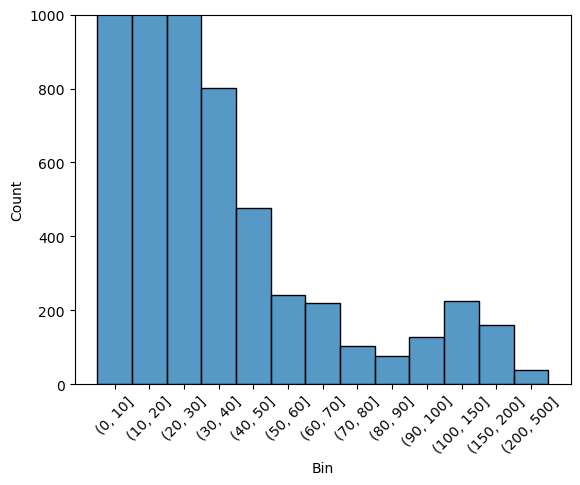

In [60]:
sns.histplot(testt['Bin'])
plt.ylim(0,1000)
plt.xticks(rotation=45); # Rotate labels 45 degrees

### troubleshoot

In [ ]:
# test = ddf_ne.get_partition(0).compute()

In [ ]:
# test = test.drop(test.columns[1:11], axis=1)

In [ ]:
# test.melt(id_vars=['NHDPlusID'],
#           value_vars=['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'],
#           var_name='threshold')

In [ ]:
# ddf_ne_melted = ddf_ne_melted.compute().reset_index().drop(columns='index')

In [ ]:
len(ddf_ne.NHDPlusID.unique())

In [ ]:
len(ddf_ne_melted.NHDPlusID.unique())

In [ ]:
# ne = ddf_ne_melted[ddf_ne_melted['coverage'] != 0]

In [ ]:
# ne = ne[ne['threshold'] == thresholds[4]].reset_index().drop(columns='index')

In [ ]:
# ne.compute()

In [ ]:
ddf_ne = ddf_ne.drop(list(ddf_ne.columns[-9:]), axis=1)

In [ ]:
temp = ddf_ne_melted.merge(right=ddf_ne, how='left', on='NHDPlusID').reset_index()

In [ ]:
temp.compute().iloc[[0]].NHDPlusID

In [ ]:
temp = temp.compute()

In [ ]:
temp.iloc[0].NHDPlusID

In [ ]:
temp[(temp.threshold == '0.5')].shape

In [ ]:
temp[(temp.threshold == '0.5') & (temp.coverage != 0)].shape

In [ ]:
temp[(temp.threshold == '0.5') & (temp.coverage != 0) & ~(temp.swot_slope.isna())]

In [ ]:
zeros = temp[temp['coverage'] == 0]

In [ ]:
ne = temp[temp['coverage'] != 0]

In [ ]:
ne['coverage'] = ne['coverage']*10

In [ ]:
ne = ne[['threshold', 'coverage', 'Bin', 'alignment']]

In [ ]:
ne = ne[ne['threshold'] == thresholds[4]].reset_index().drop(columns='index')

In [ ]:
ne.columns

In [ ]:
ne = ne.merge(ddf_ne[['NHDPlusID', bbin]], how='left', on='NHDPlusID')

In [ ]:
ne = ne.drop(columns='NHDPlusID')

In [ ]:
ne.compute()

In [ ]:
# test = ne.sample(frac=0.00005)

In [ ]:
del ddf_ne, ddf_ne_melted, temp

In [ ]:
# testy = test.get_partition(0)

In [ ]:
# testy = testy.compute()

In [ ]:
# ddf_ne = ddf_ne.sample(frac=0.1)

In [ ]:
# ne = ddf_ne[ddf_ne['threshold'] == thresholds[8]].reset_index()#.drop(columns='index')

In [ ]:
# ne = ne[['num_wse']]

In [ ]:
# del ne

In [ ]:
# ne = ne.sample(frac=0.005)

In [ ]:
# unique_val = ddf_ne['Bin'].unique()

In [ ]:
# unique_val.compute()